# Introduction to the Retina project – D7046E @ LTU.SE

This notebook serves as a starting point and playground for investigating what the 1D Retina project is about.
The idea is that you should familiarize yourself with both projects and later on decide which project to focus on (retina/SNN or chatbot/ANN).

In [2]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set default figure size
plt.rcParams['figure.figsize'] = [6,6]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Basic data generator

The following animation illustrates a simple motion detection task. A bright spot is moving across a one-dimensonal array of virtual receptor neurons.

![Concept illustration](https://drive.google.com/uc?export=view&id=1dc4TQ84ui5i9oVnGH9Au5sZfHKzt-2jd)

The task is to determine whether the pattern is moving and whether it is moving towards the left or right. The following code implements a basic spike data generator inspired by the animation above. For simplicity it is assumed that a bright spot is moving at constant speed back and forth, and that one spike is generated when the bright spot is passing over a receptor neuron.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1] [0, 0.05263157894736842, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.42105263157894735, 0.47368421052631576, 0.5263157894736842, 0.5789473684210527, 0.631578947368421, 0.6842105263157894, 0.7368421052631577, 0.7894736842105261, 0.8421052631578945, 0.8947368421052628, 0.9473684210526312, 0.9999999999999996, 1.052631578947368, 1.1052631578947363, 1.1578947368421046, 1.210526315789473, 1.2631578947368414, 1.3157894736842097, 1.368421052631578, 1.4210526315789465, 1.4736842105263148, 1.5263157894736832, 1.5789473684210515, 1.63157894736842, 1.6842105263157883, 1.7368421052631566, 1.789473684210525, 1.8421052631578934, 1.8947368421052617, 1.94736842105263]


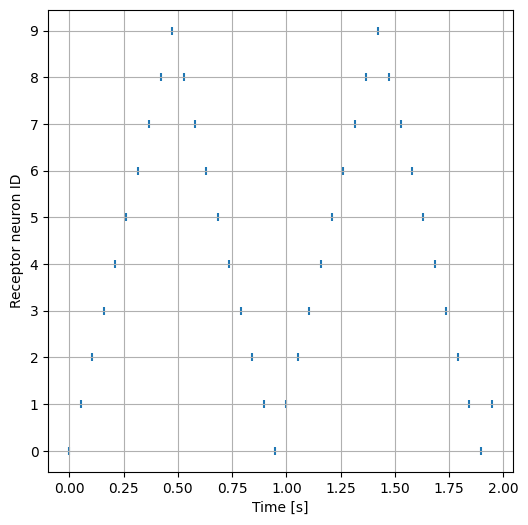

In [8]:
####################################################################################################
# Simulation parameters
dt = 1e-4                    # Timestep
t = np.arange(0,20000)*dt    # Simulation time array t
num_receptors = 10           # Number of receptor neurons
speed = 20                   # Speed of bright spot, number of receptor neurons passed per second
####################################################################################################

plot_t = []                  # Time of spikes
plot_n = []                  # Receptor neuron id's
currtime = 0                 # Time when a spike is fired
neuronid = 0                 # Neuron that fires a spike
stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# Make placeholders for spike time arrays to be used for SNN simulation
spikes = []
for i in range(num_receptors):
    spikes.append([])

# Generate and plot spikes from receptor neurons
while currtime < t[-1]:
    plot_t.append(currtime)
    plot_n.append(neuronid)
    spikes[neuronid].append(currtime)
    if neuronid == 0 and stepdir == -1:
        stepdir = 1
    elif neuronid == (num_receptors-1) and stepdir == 1:
        stepdir = -1
    neuronid += stepdir
    currtime += timestep
    
# Plot spikes
fig, ax = plt.subplots()
rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
ax.grid()
print(plot_n, plot_t)

# Implement your first motion-detection SNN

There is a direction-selective network example in [Neuronify](https://ovilab.net/neuronify/), which is illustrated below. This network is designed so that the output neuron tends to fire a spike when the inputs are touched from right to left, but not when touched from left to right (with some limitations on the touching speed).

![First network implementation](https://drive.google.com/uc?export=view&id=1ZIyhUCtNebN1StlYCKEnC0qgXMZAF8d-)

Can you simulate this network using the code from SNN Exercise 1 and the input spikes provided by the data generator above? Can you modify the parameters of the simulated network so that it becomes direction selective?

If you succeed with this task then you have designed your first SNN vision system capable of basic motion detection!

**Note:** You need to complete SNN Exercise 1 to acquire the necessary background knowledge for this task.

In [4]:
# To simulate the spikes from the receptor neurons you will need an additional neuron constructor defined as

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
}

# To incorporate this neuron type in the simulator you will need to update the spikegen(dt,t,neurons) function

def spikegen(dt, t, neurons):
    # This function implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
    return spikes

# With these modifications of the simulator code you should be able to simulate the receptor neurons using
# spike_generator neurons initialized with the spike time arrays produced by the data generator code above.

# The construction of neurons and configuration of synapses should be done in a similar way as in SNN Exercise 1.

In [5]:
def lif_cic_neuron(I_syn, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3):
    # LIF neuron with a constant input current I_syn
    return {
        'type'    : 'lif_cic',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_syn'   : I_syn,                     # Postsynaptic current [Ampere]
    }

def lif_neuron(num_synapses,  u_rest=-65e-3, u_reset=-80e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3, tau_syn=50e-3):
    # LIF neuron with current-based synapses (see lecture)
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'tau_syn' : tau_syn,                   # Synapse time constant [second] (can also be an array)
        'I_syn'   : np.zeros(num_synapses),    # Postsynaptic currents [Ampere]
        'w_syn'   : np.zeros(num_synapses)     # Synaptic weights [Ampere]
    }

def integrate(dt, t, neurons):
    # This function integrates the membrane potential, synaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif_cic':
            dudt = (n['u_rest'] - n['u'] + n['R']*n['I_syn']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] == 'lif':
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            dudt = (n['u_rest'] - n['u'] + n['R']*sum(n['I_syn'])) / n['tau_m']
            n['u'] += dt*dudt

def snn_update(dt, t, neurons, connections):
    # This function updates the state of a spiking neural network by calling the functions above
    spikes = spikegen(dt, t, neurons)
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                if neurons[post]['type'] == 'lif':
                    neurons[post]['I_syn'][syn] += neurons[post]['w_syn'][syn]
                else:
                    print('Error: Spike sent to neuron type without synapses')
    integrate(dt, t, neurons)
    return spikes

In [6]:
spikeTiming = [1]

# Right to left
spike1 = spike_generator([0.30])
spike2 = spike_generator([0.25])
spike3 = spike_generator([0.20])
spike4 = spike_generator([0.15])
spike5 = spike_generator([0.1])
# Left to right
# spike1 = spike_generator([0.10])
# spike2 = spike_generator([0.15])
# spike3 = spike_generator([0.20])
# spike4 = spike_generator([0.25])
# spike5 = spike_generator([0.30])

inp1 = lif_neuron(1)
inp2 = lif_neuron(1)
inp3 = lif_neuron(1)
inp4 = lif_neuron(1)
inp5 = lif_neuron(1)

feed1 = lif_neuron(1)
feed2 = lif_neuron(1)
feed3 = lif_neuron(1)
feed4 = lif_neuron(1)

relay1 = lif_neuron(2)
relay2 = lif_neuron(2)
relay3 = lif_neuron(2)
relay4 = lif_neuron(2) 

output = lif_neuron(4) 
#             0     1       2       3       4       5      6    7      8     9    10     11     12      13      14      15     16       17      18
neurons = [spike1, spike2, spike3, spike4, spike5, inp1, inp2, inp3, inp4, inp5, feed1, feed2, feed3, feed4, relay1, relay2, relay3, relay4, output]               # A population of three neurons

connections = [
    #Input
    [5,0,0],
    [6,0,1],
    [7,0,2],
    [8,0,3],
    [9,0,4],

    #Feed forward inhib
    [10,0,5],
    [11,0,6],
    [12,0,7],
    [13,0,8],

    #Relays
    [14,1,10],
    [14,0,6],
    [15,1,11],
    [15,0,7],
    [16,1,12],
    [16,0,8],
    [17,1,13],
    [17,0,9],

    #Output
    [18,0,14],
    [18,1,15],
    [18,2,16],
    [18,3,17]
]

wsyn = 350e-12

for i in range(len(neurons)): 
    if(neurons[i]["type"] == "generator"):
        continue
    try:
        neurons[i]['w_syn'][0] = wsyn
        neurons[i]['w_syn'][1] = wsyn
        neurons[i]['w_syn'][2] = wsyn
        neurons[i]['w_syn'][3] = wsyn
    except:
        pass
    if(i >13 and i < 18):
        neurons[i]['w_syn'][1] = -wsyn
    if(i == 18):
        neurons[i]['w_syn'][0] = wsyn/2
        neurons[i]['w_syn'][1] = wsyn/2
        neurons[i]['w_syn'][2] = wsyn/2
        neurons[i]['w_syn'][3] = wsyn/2
    

t = 0                                # Reset the simulation time

In [7]:
dt = 1e-5

t0 = t
tv = []
u1 = []
u2 = []
u3 = []
u_out = []
t_spike = []
n_spike = []

while t < t0+1:

    # Update the network
    spikes = snn_update(dt, t, neurons, connections)
    
    # Store membrane potentials of n1 and n2 for plotting/analysis
    tv.append(t)
    u1.append(inp5['u'])
    u2.append(feed4['u'])
    u3.append(relay4['u'])
    u_out.append(output['u'])
    
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt
    
plt.rcParams['figure.figsize'] = [10, 10]
fig,(ax1,ax2,ax3,ax4, ax5) = plt.subplots(5,1, sharex=True)
ax1.plot(tv,u1); ax1.set_ylabel('Membrane potential inp1(t)')
ax2.plot(tv,u2); ax2.set_ylabel('Membrane potential relay1(t)')
ax3.plot(tv,u3); ax3.set_ylabel('Membrane potential output(t)')
ax4.plot(tv,u_out); ax4.set_ylabel('Membrane potential output(t)')
rasterplot(ax5, t_spike, n_spike,'Time [s]','Neuron index')

KeyboardInterrupt: 

# Further project work 

The challenge for the **1D Retina project** is to develop a more advanced vision system for (1D) motion classification, which is not limited to one specific pattern like the bright spot in the basic data generator above.

For example, you could consider using an open image dataset for training, validation and testing. For testing, the output of a webcam could optionally be considered. The delta modulator concept introduced in SNN Exercise 1 could potentially be used to convert pixel intensities to spikes. Optionally, you can use a [DAVIS346 neuromorphic vision sensor](https://inivation.github.io/inivation-docs/Hardware%20user%20guides/User_guide_-_DAVIS346.html) to record your own dataset.

Some inspiration for the SNN network architecture and training protocol can be obtained also from SNN Exercise 2. The [Reichardt Detector](https://en.wikipedia.org/wiki/Motion_perception#The_Reichardt-Hassenstein_model) is one starting point. For further inspiration, consider for example [motion detection in insects](https://link.springer.com/content/pdf/10.1007/s00359-019-01375-9.pdf).

In addition to considering differnt types of receptor models and SNN architectures for efficient and reliable motion classification, you can consider using other SNN simulators like [Brian2](https://brian2.readthedocs.io). Optionally you can consider using accelerators like [Brian2GeNN](https://brian2genn.readthedocs.io/en/stable/introduction/).

The possibilities for exploration are endless! How does the human retina work?